# 作用于圆环的二维Poisson问题

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/physics_driven/mindspore_poisson_ring.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/physics_driven/mindspore_poisson_ring.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/physics_driven/poisson_ring.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class，mindspore.jacrev*。


## 概述

泊松方程是一个在理论物理中具有广泛效用的椭圆偏微分方程。例如，泊松方程的解是由给定电荷或质量密度分布引起的势场；在已知势场的情况下，可以计算静电或引力（力）场。

## 问题描述

我们从二维齐次泊松方程出发，

$$
f + \Delta u = 0
$$

其中 `u` 是主变量， `f` 是源项， $\Delta$ 表示拉普拉斯运算符。

我们考虑源项 `f` ($f=1.0$)则泊松方程可以表示为：

$$
\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} + 1.0 = 0,
$$

本案例中，使用Dirichlet边界条件和Neumann边界条件。格式如下：

外圆边界上的Dirichlet边界条件：

$$
u = 0
$$

内圆边界上的Neumann边界条件：

$$
du/dn = 0
$$

本案例利用PINNs方法学习 $(x, y) \mapsto u$，实现泊松方程的求解。

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器。
4. Poisson2D。
5. 模型训练。
6. 模型推理及可视化。

In [1]:
import time
import numpy as np
import sympy

from mindspore import nn, ops, Tensor, set_context, set_seed, jit
from mindspore import dtype as mstype
import mindspore as ms


下述`src`包可以在[applications/physics_driven/poisson_ring/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/physics_driven/poisson_ring/src)下载。

In [2]:
from mindflow.pde import Poisson, sympy_to_mindspore
from mindflow.cell import MultiScaleFCCell
from mindflow.utils import load_yaml_config

from src import create_training_dataset, create_test_dataset, calculate_l2_error, visual_result


set_seed(123456)
set_context(mode=ms.GRAPH_MODE, device_target="GPU", device_id=5)


加载 `poisson2d_cfg.yaml` ， 用户可以修改[配置文件](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/physics_driven/poisson_ring/poisson2d_cfg.yaml)中的参数。

In [3]:
# load configurations
config = load_yaml_config('poisson2d_cfg.yaml')

## 创建数据集

本案例根据求解域、边值条件进行随机采样，生成训练数据集与测试数据集，具体设置如下：

In [4]:
# create training dataset
dataset = create_training_dataset(config)
train_dataset = dataset.batch(batch_size=config["train_batch_size"])

# create  test dataset
inputs, label = create_test_dataset(config)

## 构建模型

本例使用简单的全连接网络，深度为6层，激活函数为`tanh`函数。

In [5]:
# define models and optimizers
model = MultiScaleFCCell(in_channels=config["model"]["in_channels"],
                         out_channels=config["model"]["out_channels"],
                         layers=config["model"]["layers"],
                         neurons=config["model"]["neurons"],
                         residual=config["model"]["residual"],
                         act=config["model"]["activation"],
                         num_scales=1)

## 优化器

In [6]:
optimizer = nn.Adam(model.trainable_params(), config["optimizer"]["initial_lr"])


## Poisson2D

`Poisson2D`包含求解问题的控制方程、狄利克雷边界条件、诺曼边界条件等。使用`sympy`以符号形式定义偏微分方程并求解所有方程的损失值。

In [7]:
class Poisson2D(Poisson):
    def __init__(self, model, loss_fn=nn.MSELoss()):
        super(Poisson2D, self).__init__(model, loss_fn=loss_fn)
        self.bc_outer_nodes = sympy_to_mindspore(self.bc_outer(), self.in_vars, self.out_vars)
        self.bc_inner_nodes = sympy_to_mindspore(self.bc_inner(), self.in_vars, self.out_vars)

    def bc_outer(self):
        bc_outer_eq = self.u
        equations = {"bc_outer": bc_outer_eq}
        return equations

    def bc_inner(self):
        bc_inner_eq = sympy.Derivative(self.u, self.normal) - 0.5
        equations = {"bc_inner": bc_inner_eq}
        return equations

    def get_loss(self, pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_loss = self.loss_fn(pde_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_inner_res = self.parse_node(self.bc_inner_nodes, inputs=bc_inner_data, norm=bc_inner_normal)
        bc_inner_loss = self.loss_fn(bc_inner_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_outer_res = self.parse_node(self.bc_outer_nodes, inputs=bc_outer_data)
        bc_outer_loss = self.loss_fn(bc_outer_res[0], Tensor(np.array([0.0]), mstype.float32))

        return pde_loss + bc_inner_loss + bc_outer_loss


## 模型训练

使用**MindSpore >= 2.0.0**的版本，采用函数式编程的方式训练网络。

In [8]:
def train():
    problem = Poisson2D(model)

    def forward_fn(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
        loss = problem.get_loss(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal)
        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
        loss, grads = grad_fn(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    steps = config["train_steps"]
    sink_process = ms.data_sink(train_step, train_dataset, sink_size=1)
    model.set_train()
    for step in range(steps):
        local_time_beg = time.time()
        cur_loss = sink_process()
        if step % 100 == 0:
            print(f"loss: {cur_loss.asnumpy():>7f}")
            print("step: {}, time elapsed: {}ms".format(step, (time.time() - local_time_beg) * 1000))
            calculate_l2_error(model, inputs, label, config["train_batch_size"])
    visual_result(model, inputs, label, step+1)


In [9]:
time_beg = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - time_beg))

poission: Derivative(u(x, y), (x, 2)) + Derivative(u(x, y), (y, 2)) + 1.0
    Item numbers of current derivative formula nodes: 3
bc: u(x, y)
    Item numbers of current derivative formula nodes: 1
bc_r: Derivative(u(x, y), n) - 0.5
    Item numbers of current derivative formula nodes: 2


loss: 1.257777
step: 0, time elapsed: 7348.472833633423ms
    predict total time: 151.28588676452637 ms
    l2_error:  1.1512688311539545
loss: 0.492176
step: 100, time elapsed: 246.30475044250488ms
    predict total time: 1.9807815551757812 ms
    l2_error:  0.7008664085681209
loss: 0.006177
step: 200, time elapsed: 288.0725860595703ms
    predict total time: 2.8748512268066406 ms
    l2_error:  0.035529497589628596
loss: 0.003083
step: 300, time elapsed: 276.9205570220947ms
    predict total time: 4.449129104614258 ms
    l2_error:  0.034347416303136924
loss: 0.002125
step: 400, time elapsed: 241.45269393920898ms
    predict total time: 1.9965171813964844 ms
    l2_error:  0.024273206318798948
...
loss: 0.000126
step: 4500, time elapsed: 245.61786651611328ms
    predict total time: 8.903980255126953 ms
    l2_error:  0.009561532889489787
loss: 0.000145
step: 4600, time elapsed: 322.16882705688477ms
    predict total time: 7.802009582519531 ms
    l2_error:  0.015489169733942706
loss:

## 模型推理及可视化

训练后可对流场内所有数据点进行推理，并可视化相关结果。

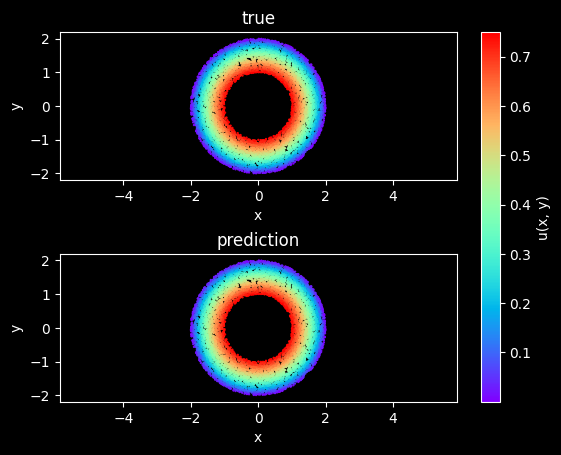

In [10]:
# visualization
steps = config["train_steps"]
visual_result(model, inputs, label, steps+1)